In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from sklearn.impute import KNNImputer
from collections import Counter

# For Int
import sys
import os
import numpy as np
import pandas as pd
import scipy.stats as ss


# For PCA
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
import matplotlib.pyplot
import matplotlib.pyplot as plt

In [2]:
# will we draw all?
draw_boxplots_flag = False
draw_histplots_flag = False
draw_first_histplot_flag = False

In [3]:
DRAW_DATA_SEX_PCA = "./draw_data/sex_pca.tsv"
DRAW_DATA_DEATH_PCA = "./draw_data/death_pca.tsv"

PHENO_BEFORE = "./data/extra_FINAL_PHENO_ALL_LAUNCHES.tsv"
PHENO_FOR_R_PLOTS = "draw_data/boxplots_analyses.tsv"
PHENO_TO_SAVE = "data/pheno_filtered_INT_sd3.tsv"
PHENO_UNNORM_TO_SAVE = "data/pheno_filtered_without_INT_sd3.tsv"

In [4]:
def print_info(data):
    print(data.info())
    print(f"\n### Shape:{data.shape}\n")
    print(f"\n### Percentage of not-nans:")
    for key, value in data.iteritems():
        print("--------------------")
        print(
            f"{key}: {np.round((~data[key].isna()).sum()/data[key].shape[0]*100, 1)}%"
        )
    print("\n### Columns and Unique Values:")
    for key, value in data.iteritems():
        print("--------------------")
        print(f"Columns: {key}")
        print(f"Amount of unique values: {value.unique().shape}")
        print(f"Values: {value.unique()}")

        print("--------------------")


def draw_histplots(data, cols, flag=True):
    if flag:
        for col in cols:
            sns.histplot(data[col])
            plt.show()


def impute(data, n_neighbors=5):
    imputer = KNNImputer(n_neighbors=n_neighbors)
    return pd.DataFrame(
        imputer.fit_transform(data), columns=data.columns, index=data.index
    )


# from: https://github.com/edm1/rank-based-INT
def rank_INT(series, c=3.0 / 8, stochastic=True):
    """Perform rank-based inverse normal transformation on pandas series.
    If stochastic is True ties are given rank randomly, otherwise ties will
    share the same value. NaN values are ignored.
    Args:
        param1 (pandas.Series):   Series of values to transform
        param2 (Optional[float]): Constand parameter (Bloms constant)
        param3 (Optional[bool]):  Whether to randomise rank of ties

    Returns:
        pandas.Series
    """

    # Check input
    assert isinstance(series, pd.Series)
    assert isinstance(c, float)
    assert isinstance(stochastic, bool)

    # Set seed
    np.random.seed(123)

    # Take original series indexes
    orig_idx = series.index

    # Drop NaNs
    series = series.loc[~pd.isnull(series)]

    # Get ranks
    if stochastic == True:
        # Shuffle by index
        series = series.loc[np.random.permutation(series.index)]
        # Get rank, ties are determined by their position in the series (hence
        # why we randomised the series)
        rank = ss.rankdata(series, method="ordinal")
    else:
        # Get rank, ties are averaged
        rank = ss.rankdata(series, method="average")

    # Convert numpy array back to series
    rank = pd.Series(rank, index=series.index)

    # Convert rank to normal distribution
    transformed = rank.apply(rank_to_normal, c=c, n=len(rank))

    return transformed


def rank_to_normal(rank, c, n):
    # Standard quantile function
    x = (rank - c) / (n - 2 * c + 1)
    return ss.norm.ppf(x)


def do_pca(data, target):

    #     target = 'Severity'
    #     target = 'Death'

    y = data.loc[:, [target]].values
    #     imputed_DF = pd.DataFrame(SimpleImputer(missing_values=np.nan, strategy='mean').fit_transform(data))

    numerical_special_cols = list(set(numerical_cols) & set(data.columns))
    imputed_DF = pd.DataFrame(
        KNNImputer(missing_values=np.nan, n_neighbors=5).fit_transform(
            data[numerical_special_cols]
        )
    )
    imputed_DF.columns = numerical_special_cols
    imputed_DF.index = data.index
    data = imputed_DF

    x = data.loc[:, numerical_special_cols].values  # Separating out the target

    x = StandardScaler().fit_transform(x)

    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(x)
    principal_data = pd.DataFrame(
        data=principal_components,
        columns=["principal component 1", "principal component 2"],
        index=data.index,
    )
    principal_data[target] = y
    #     final_data =
    #     final_data = pd.concat([, pd.Series(y)], axis = 1)
    # объясненная дисперсия
    print(f"Объясненная дисперсия: {pca.explained_variance_ratio_}")
    return principal_data


def draw_pca(final_data, target, targets=None, colors=None):

    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(1, 1, 1)
    ax.set_xlabel("Principal Component 1", fontsize=15)
    ax.set_ylabel("Principal Component 2", fontsize=15)
    ax.set_title(f"2 component PCA by {target}", fontsize=20)

    if not targets:
        targets = final_data[target].unique()
    if not colors:
        colors = ["r", "g", "b", "fuchsia", "sienna"]

    for cur_target, color in zip(targets, colors):
        indicesToKeep = final_data[target] == cur_target
        ax.scatter(
            final_data.loc[indicesToKeep, "principal component 1"],
            final_data.loc[indicesToKeep, "principal component 2"],
            c=color,
            s=50,
        )
    ax.legend(targets)
    ax.grid()
    plt.show()


def delete_outliers(data, sd=3):
    return data.mask(data.sub(data.mean()).div(data.std()).abs().gt(sd))


def high_coverage(data, cutoff):
    cov = dict()
    cov_cols = []
    for key, value in data.iteritems():
        flag = (~data[key].isna()).sum() / data[key].shape[0] * 100 > cutoff
        cov.update({key: flag})
        if flag:
            cov_cols.append(key)
    print(f"Values > {cutoff}%: " + str(Counter(cov.values())))
    return cov_cols

## Data exploration

In [5]:
data = pd.read_csv(PHENO_BEFORE, sep="\t", index_col="launch_blood_id")
print(data.shape)
data.tail()

(840, 133)


,launch_id,man_id,storm,ill_to_hosp,temp,chd,aks,cvd,news_1,resp_fail_5,...,l_max_min,ldh_max_min,fer_max_min,d_dym_max_min,creat_max_min,glu_max_min,pcr_max_min,news,news_max_min,week_to_hosp
launch_blood_id,,,,,,,,,,,,,,,,,,,,,
114118,11,660644,1.0,8.0,1.0,0.0,0.0,0.0,6.0,3.0,...,0.87,0.0,49.7,NaN,3.0,0.00,0.00,11.0,9.0,1.0
114119,11,660141,1.0,7.0,1.0,0.0,0.0,0.0,4.0,1.0,...,0.48,NaN,434.2,1.58,11.0,5.75,7.90,5.0,5.0,0.0
114120,11,29478,1.0,3.0,1.0,0.0,0.0,0.0,4.0,1.0,...,0.43,0.0,9.4,0.00,NaN,NaN,0.00,4.0,4.0,NaN
114121,11,660907,1.0,6.0,1.0,1.0,1.0,1.0,2.0,1.0,...,1.33,0.0,125.4,NaN,13.0,1.13,7.01,4.0,4.0,0.0
114122,11,661492,1.0,9.0,1.0,0.0,0.0,0.0,6.0,2.0,...,0.29,0.0,597.4,0.04,1.0,0.00,NaN,8.0,8.0,1.0


In [6]:
# get indexes, where com_index = 4
com_4_indexes = data[data.com_index == 4].index

In [7]:
print_info(data)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 840 entries, 104555 to 114122
Columns: 133 entries, launch_id to week_to_hosp
dtypes: float64(128), int64(2), object(3)
memory usage: 879.4+ KB
None

### Shape:(840, 133)


### Percentage of not-nans:
--------------------
launch_id: 100.0%
--------------------
man_id: 100.0%
--------------------
storm: 97.5%
--------------------
ill_to_hosp: 45.4%
--------------------
temp: 69.4%
--------------------
chd: 70.5%
--------------------
aks: 70.5%
--------------------
cvd: 70.4%
--------------------
news_1: 56.1%
--------------------
resp_fail_5: 50.4%
--------------------
news_5: 50.5%
--------------------
resp_fail_out: 55.5%
--------------------
il6: 63.6%
--------------------
crp: 92.7%
--------------------
leuk: 93.7%
--------------------
neut: 93.7%
--------------------
l: 95.1%
--------------------
ldh: 43.3%
--------------------
fer: 53.5%
--------------------
d_dym: 59.4%
--------------------
creat: 92.1%
--------------------
glu: 5

Values: [ 2.93  1.66  0.99  1.07  1.02  0.85  0.82  1.53  0.64  0.81  0.88  1.29
  1.23  0.69  2.8   1.3   0.41  1.15  0.68  0.78   nan  2.87  1.11  0.86
  1.32  1.39  0.62  0.65  0.57  1.09 19.09  1.77  1.59  0.55  1.14  0.95
  0.58  0.36  0.29  1.03  2.08  1.88  1.47  1.62  1.22  0.98  0.63  1.57
  1.1   1.16  3.77  1.63  0.48  2.46  1.04  1.61  1.94  1.85  0.7   0.87
  1.92  0.56  1.65  2.45  2.6   2.55  1.13  0.47  1.58  1.79  1.72  1.08
  0.74  2.44  1.78  1.82  1.28  2.63  0.91  1.98  2.29  0.94  1.01  1.27
  0.73  2.09  1.45  2.37  1.5   1.33  0.83  2.3   1.26  2.36  1.25  2.19
  1.7   2.07  1.69  2.95  0.66  1.52  1.42  0.97  1.37  0.84  0.9   2.22
  1.21  1.49  1.4   2.16  2.21  3.24  0.93  1.05  0.75  0.51  1.6   0.44
  0.38  0.19  0.71  2.76  0.61  0.96  1.44  1.56  2.84  1.19  2.72  2.78
  1.9   1.12  1.99  0.45  2.57  0.79  1.95  2.25  0.8   1.96  1.24  2.04
  1.18  1.36  1.67  0.89  2.03  1.48  2.65  0.72  0.59  2.    2.11  2.12
  1.51  1.93  1.86  2.77  2.61  1.43  0.67 

Values: [      nan 2.434e+01 2.374e+02 5.901e+01 2.398e+01 1.684e+02 3.044e+01
 3.113e+01 1.107e+02 1.161e+01 9.235e+02 1.371e+02 1.272e+02 1.018e+02
 8.321e+01 3.145e+01 8.130e+01 5.154e+02 9.627e+01 7.366e+01 6.100e+00
 1.348e+01 2.541e+01 5.082e+01 4.492e+01 3.635e+01 1.664e+01 1.042e+02
 1.951e+01 1.063e+01 1.197e+02 1.682e+02 1.173e+02 1.084e+02 2.050e+00
 2.189e+02 4.399e+01 9.750e+01 1.012e+01 5.412e+01 5.170e+00 3.300e+00
 2.609e+01 1.520e+00 3.651e+01 3.060e+00 5.834e+01 2.503e+01 7.184e+01
 6.460e+01 7.470e+00 7.444e+01 2.691e+01 1.368e+01 1.082e+01 6.148e+01
 4.216e+01 5.251e+01 2.622e+01 6.551e+01 1.280e+01 2.323e+02 1.704e+01
 1.500e+00 2.620e+00 5.198e+01 7.928e+01 5.620e+00 4.156e+01 3.470e+02
 1.117e+01 1.074e+02 6.710e+00 2.051e+02 1.531e+01 2.648e+01 7.170e+00
 7.570e+00 1.619e+02 3.856e+01 9.660e+00 1.854e+02 8.010e+00 1.314e+02
 1.801e+01 3.394e+01 1.768e+01 3.307e+01 5.139e+01 0.000e+00 2.246e+01
 2.550e+01 5.250e+00 2.031e+01 4.574e+01 2.178e+02 5.572e+01 1.086e+0

In [8]:
data.columns, data.shape

(Index(['launch_id', 'man_id', 'storm', 'ill_to_hosp', 'temp', 'chd', 'aks',
        'cvd', 'news_1', 'resp_fail_5',
        ...
        'l_max_min', 'ldh_max_min', 'fer_max_min', 'd_dym_max_min',
        'creat_max_min', 'glu_max_min', 'pcr_max_min', 'news', 'news_max_min',
        'week_to_hosp'],
       dtype='object', length=133),
 (840, 133))

Look for some basic associations and dependencies

<AxesSubplot:>

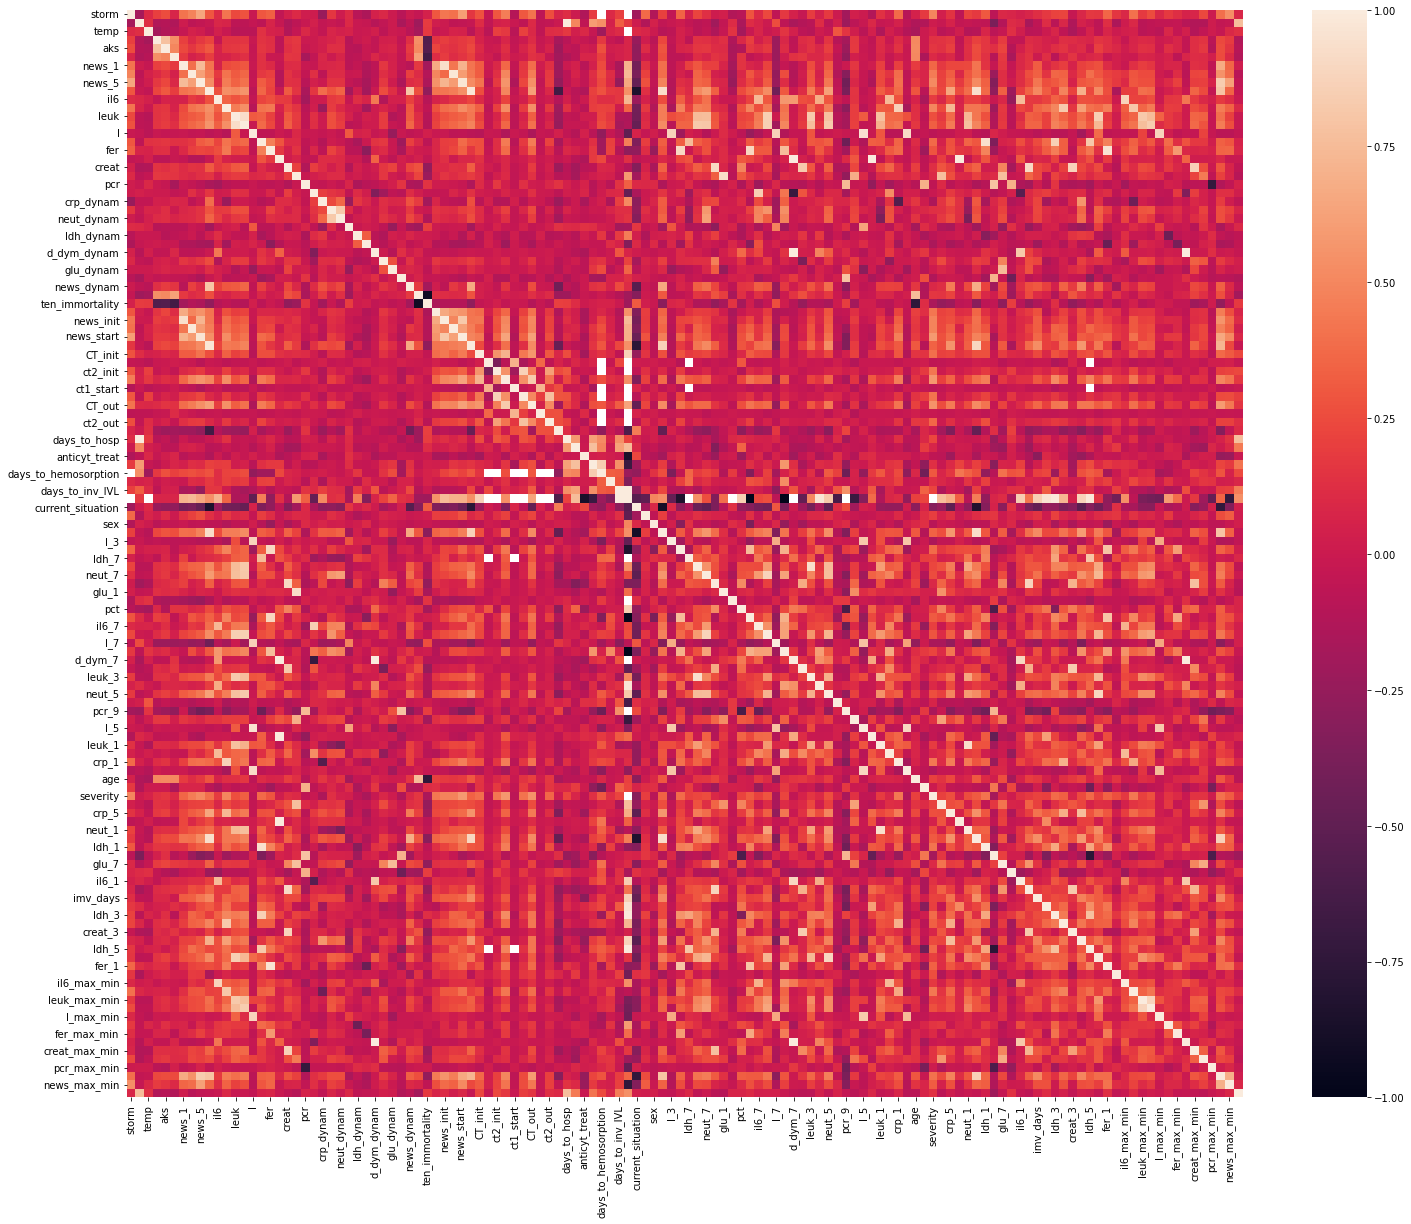

In [9]:
fig, ax = plt.subplots(figsize=(25, 20))
sns.heatmap(data.drop(["launch_id", "man_id"], axis=1).corr())
# plt.savefig("heatmap.pdf")
# plt.show()

#### Save data for r boxplots

In [10]:
cols_to_import = [
    "il6",
    "crp",
    "leuk",
    "neut",
    "l",
    "ldh",
    "fer",
    "d_dym",
    "creat",
    "glu",
    "pcr",
    "news",
    "CT_start",
    "death",
    "severity",
]
data[cols_to_import].to_csv(PHENO_FOR_R_PLOTS, sep="\t", index=False)

## Overall distribution

Let's build distributions for all the columns, just to look at the data.

In [11]:
id_cols = ["man_id", "launch_id"]

categorical_cols = [
    "BACT_sum",
    "age",
    "sex",
    "death",
    "severity",
    "smell_taste_loss",
    "storm",
    "week_to_hosp",
    "smell_taste_loss",
    "news",
    "news_1",
    "news_5",
    "news_dynam",
    "news_init",
    "news_start",
    "news_out",
    "news_max_min",
    "current_situation",
    "resp_dis_init",
    "resp_dis_start",
    "resp_dis_out",
    "temp",
    "ten_immortality",
    "weakness",
    "CT_features",
    "CT_init",
    "CT_out",
    "CT_start",
    "ct1_init",
    "ct1_out",
    "ct1_start",
    "ct2_init",
    "ct2_out",
    "ct2_start",
    "com_index"
]

dont_check_cols = ["treatment", "date_in", "date_out"]

numerical_cols = list(
    set(data.columns) - set(id_cols) - set(categorical_cols) - set(dont_check_cols)
)

In [12]:
draw_histplots(data, numerical_cols + categorical_cols, draw_first_histplot_flag)

Before doing smth, 
lets make copy data to then use it for saving as data 
without imputing and with only high coverage

In [13]:
high_data = data.copy(deep=True)

In [14]:
high_data

,launch_id,man_id,storm,ill_to_hosp,temp,chd,aks,cvd,news_1,resp_fail_5,...,l_max_min,ldh_max_min,fer_max_min,d_dym_max_min,creat_max_min,glu_max_min,pcr_max_min,news,news_max_min,week_to_hosp
launch_blood_id,,,,,,,,,,,,,,,,,,,,,
104555,10,597619,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.07,0.0,0.0,0.00,5.0,NaN,12.00,0.0,0.0,0.0
1046472,10,263436,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.88,NaN,NaN,0.77,0.0,NaN,NaN,0.0,0.0,0.0
1046474,10,695634,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.92,0.0,NaN,2.32,0.0,NaN,0.00,2.0,0.0,1.0
1046475,10,694025,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.60,NaN,NaN,5.64,8.0,0.60,NaN,0.0,0.0,1.0
1046476,10,74079,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.23,0.0,0.0,5.84,211.0,2.80,8.00,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114118,11,660644,1.0,8.0,1.0,0.0,0.0,0.0,6.0,3.0,...,0.87,0.0,49.7,NaN,3.0,0.00,0.00,11.0,9.0,1.0
114119,11,660141,1.0,7.0,1.0,0.0,0.0,0.0,4.0,1.0,...,0.48,NaN,434.2,1.58,11.0,5.75,7.90,5.0,5.0,0.0
114120,11,29478,1.0,3.0,1.0,0.0,0.0,0.0,4.0,1.0,...,0.43,0.0,9.4,0.00,NaN,NaN,0.00,4.0,4.0,NaN


In [15]:
high_coverage(high_data, 55)
high_coverage(high_data, 70)
cov_75_cols = high_coverage(high_data, 75)
high_coverage(high_data, 85)
high_coverage(high_data, 95)
high_coverage(high_data, 99)

Values > 55%: Counter({True: 90, False: 43})
Values > 70%: Counter({True: 69, False: 64})
Values > 75%: Counter({False: 73, True: 60})
Values > 85%: Counter({False: 79, True: 54})
Values > 95%: Counter({False: 99, True: 34})
Values > 99%: Counter({False: 113, True: 20})


['launch_id',
 'man_id',
 'news_dynam',
 'treatment',
 'com_index',
 'ten_immortality',
 'news_init',
 'resp_dis_start',
 'news_start',
 'resp_dis_out',
 'days_to_hosp',
 'BACT_sum',
 'sex',
 'age',
 'severity',
 'news_out',
 'days_at_hosp',
 'news',
 'news_max_min',
 'week_to_hosp']

In [16]:
high_data_deleted = list(set(high_data.columns) - set(cov_75_cols))
high_data = high_data[cov_75_cols]
high_data.shape

(840, 60)

In [17]:
len(set(high_data.columns)  & set(numerical_cols))

26

In [18]:
len(set(high_data.columns)  & set(categorical_cols))

31

## Ditributions of coverages: 

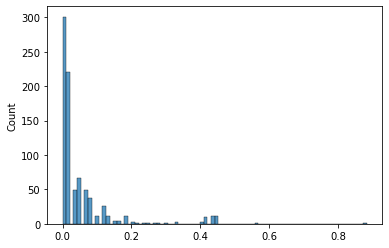

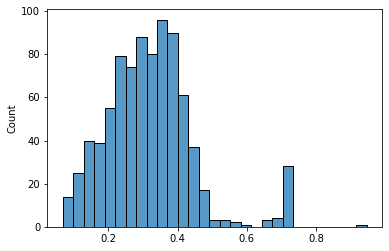

In [19]:
nans_by_man = []
for key, row in high_data.iterrows():
    nans_by_man.append(row.isnull().sum() / high_data.shape[1])
sns.histplot(nans_by_man)
plt.show()


nans_by_man = []
for key, row in data.iterrows():
    nans_by_man.append(row.isnull().sum() / data.shape[1])
sns.histplot(nans_by_man)
plt.show()

## Delete outliers

We want to __delete outliers__ (let's take $3 \sigma$ to the left and to the right) - that is just for numerical colimns.

In [20]:
masked_data = delete_outliers(data, sd=3)
masked_high_data = delete_outliers(high_data, sd=3)

draw_histplots(masked_data, numerical_cols, draw_histplots_flag)

/home/achangalidi/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:152: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


## Boxplots

In [21]:
if draw_boxplots_flag:
    for cat_col in categorical_cols:
        print(f"=====\n{cat_col.upper()}\n=====")
        for num_col in numerical_cols:
            print(f"-----\n{num_col}\n-----")
            if cat_col == "age":
                sns.set(rc={"figure.figsize": (19, 8)})
                plt.xticks(rotation=90)
            else:
                sns.set(rc={"figure.figsize": (10, 5)})
                plt.xticks(rotation=0)
            sns.boxplot(y=masked_data[num_col], x=masked_data[cat_col])
            plt.show()

## PCA

Объясненная дисперсия: [0.17642987 0.05715624]


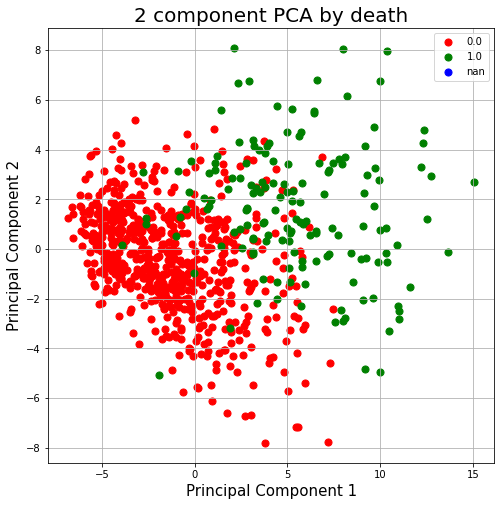

In [22]:
target = "death"
pca_data_death = do_pca(masked_data, target)
draw_pca(pca_data_death, target)

In [23]:
pca_data_death.rename(
    columns={
        "principal component 1": "PC1 (17.78%)",
        "principal component 2": "PC2 (5.84%)",
    }
)

,PC1 (17.78%),PC2 (5.84%),death
launch_blood_id,,,
104555,-5.251393,0.307942,0.0
1046472,-1.722065,-1.496355,0.0
1046474,1.934327,-1.862358,0.0
1046475,0.398871,-2.025129,0.0
1046476,3.710759,2.447661,0.0
...,...,...,...
114118,1.165000,-4.628174,0.0
114119,1.350033,-0.526411,0.0
114120,-3.289036,-0.425876,NaN


In [24]:
pca_data_death.rename(
    columns={
        "principal component 1": "PC1",
        "principal component 2": "PC2",
    }
).to_csv(DRAW_DATA_DEATH_PCA, sep="\t")

Объясненная дисперсия: [0.27370388 0.11861826]


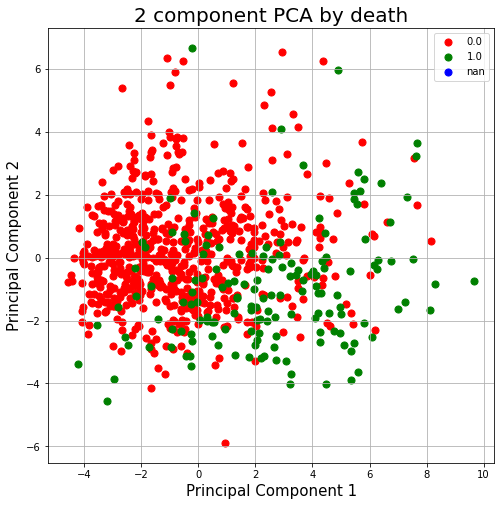

In [25]:
pca_high_data_death = do_pca(masked_high_data, target)
draw_pca(pca_high_data_death, target)

Объясненная дисперсия: [0.17642987 0.05715624]


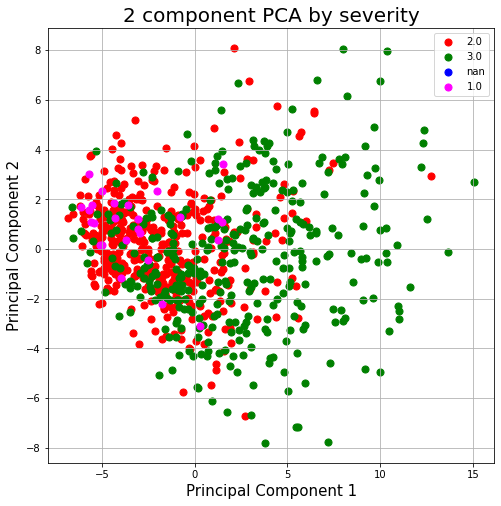

In [26]:
target = "severity"
pca_data_severity = do_pca(masked_data, target)
draw_pca(
    pca_data_severity,
    target,
)

In [27]:
pca_data_death.head()

,principal component 1,principal component 2,death
launch_blood_id,,,
104555,-5.251393,0.307942,0.0
1046472,-1.722065,-1.496355,0.0
1046474,1.934327,-1.862358,0.0
1046475,0.398871,-2.025129,0.0
1046476,3.710759,2.447661,0.0


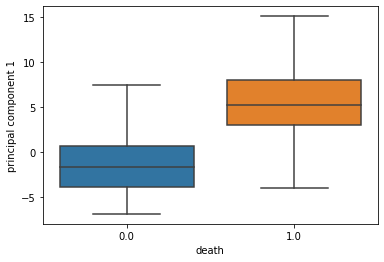

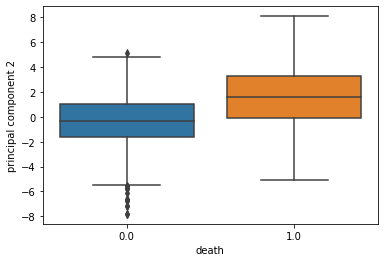

In [28]:
sns.boxplot(y=pca_data_death["principal component 1"], x=pca_data_death["death"])
plt.show()
sns.boxplot(y=pca_data_death["principal component 2"], x=pca_data_death["death"])
plt.show()

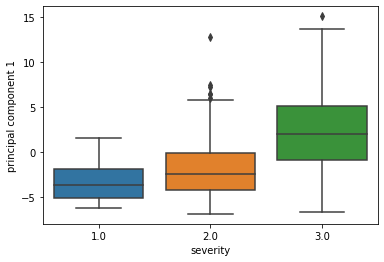

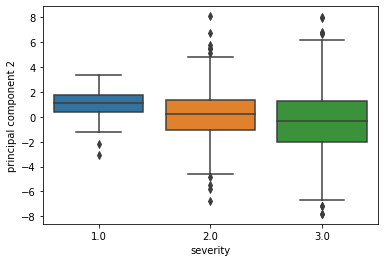

In [29]:
sns.boxplot(
    y=pca_data_severity["principal component 1"], x=pca_data_severity["severity"]
)
plt.show()
sns.boxplot(
    y=pca_data_severity["principal component 2"], x=pca_data_severity["severity"]
)
plt.show()

### By sex

Объясненная дисперсия: [0.17642987 0.05715624]


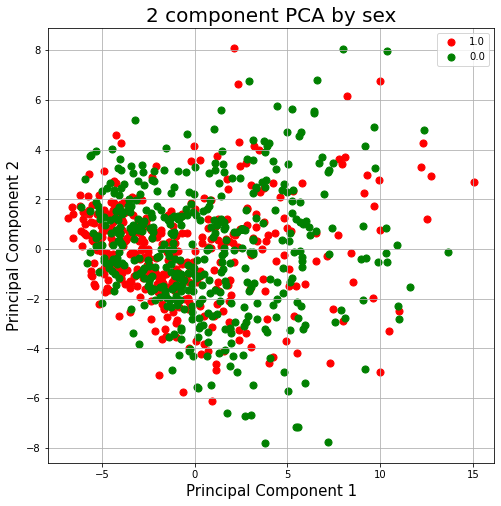

In [30]:
target = "sex"
pca_data_sex = do_pca(masked_data, target)
draw_pca(pca_data_sex, target)

In [31]:
pca_data_sex.rename(
    columns={
        "principal component 1": "PC1",
        "principal component 2": "PC2",
    }
).to_csv(DRAW_DATA_SEX_PCA, sep="\t")

## Saving dataset
Final pipeline: filter (delete outliers) ->  add PCAs -> INT normalization -> save

In [65]:
masked_data["pc1"] = pca_data_death["principal component 1"]
masked_data["pc2"] = pca_data_death["principal component 2"]

In [66]:
set(categorical_cols) & set(cov_75_cols)

{'BACT_sum',
 'CT_features',
 'CT_init',
 'CT_out',
 'CT_start',
 'age',
 'com_index',
 'ct1_init',
 'ct1_out',
 'ct1_start',
 'ct2_init',
 'ct2_out',
 'ct2_start',
 'current_situation',
 'death',
 'news',
 'news_dynam',
 'news_init',
 'news_max_min',
 'news_out',
 'news_start',
 'resp_dis_init',
 'resp_dis_out',
 'resp_dis_start',
 'severity',
 'sex',
 'smell_taste_loss',
 'storm',
 'ten_immortality',
 'weakness',
 'week_to_hosp'}

In [67]:
numerical_cols = [
    "creat",
    "creat_1",
    "creat_dynam",
    "creat_max_min",
    "crp",
    "crp_1",
    "crp_dynam",
    "crp_max_min",
    "days_at_hosp",
    "days_to_hosp",
    "l",
    "l_1",
    "l_3",
    "l_dynam",
    "l_max_min",
    "leuk",
    "leuk_1",
    "leuk_3",
    "leuk_7",
    "leuk_dynam",
    "leuk_max_min",
    "neut",
    "neut_1",
    "neut_3",
    "neut_dynam",
    "neut_max_min",
    "pc1",
    "pc2",
]

id_cols = ["man_id", "launch_id"]
categorical_cols = [
    "BACT_sum",
    "CT_features",
    "CT_init",
    "CT_out",
    "CT_start",
    "age",
    "com_index",
    "ct1_init",
    "ct1_out",
    "ct1_start",
    "ct2_init",
    "ct2_out",
    "ct2_start",
    "current_situation",
    "death",
    "news",
    "news_dynam",
    "news_init",
    "news_max_min",
    "news_out",
    "news_start",
    "resp_dis_init",
    "resp_dis_out",
    "resp_dis_start",
    "severity",
    "sex",
    "smell_taste_loss",
    "storm",
    "ten_immortality",
    "weakness",
    "week_to_hosp",
]
dont_check_cols = ["treatment"]
all_cols = id_cols + categorical_cols + numerical_cols + dont_check_cols
print(len(all_cols))

62


In [68]:
irnt_comparison_before = masked_data[numerical_cols]
irnt_comparison_before = irnt_comparison_before.add_suffix(' before IRNT')

In [69]:
int_masked_data = masked_data.copy(deep=True)

int_masked_data = int_masked_data.rename(
    columns={"10_immortality": "ten_days_immortality"}
)

int_masked_data.sex = int_masked_data.sex.astype(int)
int_masked_data["pc1"] = pca_data_death["principal component 1"]
int_masked_data["pc2"] = pca_data_death["principal component 2"]

int_masked_data.to_csv(PHENO_UNNORM_TO_SAVE, sep="\t")

int_masked_data = int_masked_data[list(high_data.columns) + ['pc1', 'pc2']]

for col in set(numerical_cols) & set(high_data.columns):
    #     print(col)
    int_masked_data[col] = rank_INT(int_masked_data[col], c=3.0 / 8, stochastic=True)

int_masked_data.to_csv(PHENO_TO_SAVE, sep="\t")

In [70]:
irnt_comparison_after = int_masked_data[numerical_cols]
irnt_comparison_after = irnt_comparison_after.add_suffix(' after IRNT')


In [71]:
irnt_comparison_after

,creat after IRNT,creat_1 after IRNT,creat_dynam after IRNT,creat_max_min after IRNT,crp after IRNT,crp_1 after IRNT,crp_dynam after IRNT,crp_max_min after IRNT,days_at_hosp after IRNT,days_to_hosp after IRNT,...,leuk_7 after IRNT,leuk_dynam after IRNT,leuk_max_min after IRNT,neut after IRNT,neut_1 after IRNT,neut_3 after IRNT,neut_dynam after IRNT,neut_max_min after IRNT,pc1 after IRNT,pc2 after IRNT
launch_blood_id,,,,,,,,,,,,,,,,,,,,,
104555,-0.333425,-0.665379,0.966979,-0.282504,-1.189100,-1.115705,0.147550,-0.683442,0.166915,-0.907882,...,-1.281552,-0.755442,1.291978,-0.170263,-0.747168,0.302957,-0.537327,0.587953,-5.251393,0.307942
1046472,0.155156,0.306479,0.388952,-0.916981,0.518273,0.798654,-1.084957,0.725092,0.794024,0.065590,...,-0.295056,-0.937849,-0.021155,-0.143870,0.205045,-0.748193,-0.610233,0.146779,-1.722065,-1.496355
1046474,-0.466717,-0.325028,0.669017,-0.613985,0.718649,1.002797,-0.942933,0.603477,0.276317,0.651465,...,1.290853,0.230723,1.561236,1.212766,1.691557,0.599284,-2.442012,1.769423,1.934327,-1.862358
1046475,-0.372332,-0.874387,-0.086630,-0.043160,0.456211,-0.649698,-0.055568,1.009356,1.238402,1.265094,...,1.137876,1.616910,0.514902,0.349110,0.276051,0.508517,1.047142,-0.246222,0.398871,-2.025129
1046476,2.194859,2.352346,-2.698284,NaN,1.264784,1.559466,-1.972522,1.754082,-0.524575,1.299781,...,-0.718228,-2.595355,1.682343,1.098427,1.545709,1.022658,-2.382357,1.696510,3.710759,2.447661
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114118,-1.439005,-1.629852,0.870545,-0.398626,-0.590099,-0.437775,-0.234079,-0.219506,2.266654,0.647701,...,0.316367,1.204457,0.281934,0.203424,-1.130099,0.667237,1.379299,0.631002,1.165000,-4.628174
114119,-1.050828,-1.124447,-0.529562,0.076410,1.089839,-0.062684,0.869057,1.124172,-0.304938,0.145313,...,NaN,1.084957,-0.614158,0.022812,-0.394223,0.491715,1.160858,-0.032507,1.350033,-0.526411
114120,NaN,NaN,NaN,NaN,-0.677290,-0.538624,0.088324,-0.638955,-0.827908,NaN,...,NaN,NaN,NaN,0.562742,0.939397,NaN,0.218129,-1.890651,-3.289036,-0.425876


In [72]:
comparison_data = pd.concat([irnt_comparison_before, irnt_comparison_after], axis = 1)
comparison_data

,creat before IRNT,creat_1 before IRNT,creat_dynam before IRNT,creat_max_min before IRNT,crp before IRNT,crp_1 before IRNT,crp_dynam before IRNT,crp_max_min before IRNT,days_at_hosp before IRNT,days_to_hosp before IRNT,...,leuk_7 after IRNT,leuk_dynam after IRNT,leuk_max_min after IRNT,neut after IRNT,neut_1 after IRNT,neut_3 after IRNT,neut_dynam after IRNT,neut_max_min after IRNT,pc1 after IRNT,pc2 after IRNT
launch_blood_id,,,,,,,,,,,,,,,,,,,,,
104555,73.0,68.0,5.0,5.0,10.6,10.6,-9.1,10.6,13.0,2.0,...,-1.281552,-0.755442,1.291978,-0.170263,-0.747168,0.302957,-0.537327,0.587953,-5.251393,0.307942
1046472,85.0,85.0,0.0,0.0,151.5,151.5,-121.9,121.9,16.0,6.0,...,-0.295056,-0.937849,-0.021155,-0.143870,0.205045,-0.748193,-0.610233,0.146779,-1.722065,-1.496355
1046474,71.0,71.0,0.0,0.0,177.9,177.9,-108.8,108.8,13.0,8.0,...,1.290853,0.230723,1.561236,1.212766,1.691557,0.599284,-2.442012,1.769423,1.934327,-1.862358
1046475,72.0,65.0,-1.0,8.0,146.4,23.1,-21.7,145.0,19.0,11.0,...,1.137876,1.616910,0.514902,0.349110,0.276051,0.508517,1.047142,-0.246222,0.398871,-2.025129
1046476,270.0,213.0,-154.0,NaN,247.7,247.7,-235.7,235.7,10.0,12.0,...,-0.718228,-2.595355,1.682343,1.098427,1.545709,1.022658,-2.382357,1.696510,3.710759,2.447661
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114118,59.0,56.0,3.0,3.0,37.8,37.8,-35.3,35.3,29.0,8.0,...,0.316367,1.204457,0.281934,0.203424,-1.130099,0.667237,1.379299,0.631002,1.165000,-4.628174
114119,64.0,62.0,-9.0,11.0,223.8,69.0,3.9,154.8,10.0,7.0,...,NaN,1.084957,-0.614158,0.022812,-0.394223,0.491715,1.160858,-0.032507,1.350033,-0.526411
114120,NaN,NaN,NaN,NaN,31.7,31.7,-11.8,11.8,9.0,NaN,...,NaN,NaN,NaN,0.562742,0.939397,NaN,0.218129,-1.890651,-3.289036,-0.425876


In [73]:
comparison_data = comparison_data.stack().reset_index(level=0, drop=True).reset_index()
comparison_data.columns = ['feature', 'value']
comparison_data.sort_values(['feature', 'value'], inplace=True)
comparison_data.to_csv('./draw_data/for_big_plot.tsv', sep = '\t', index=False)
comparison_data

,feature,value
28766,creat after IRNT,-3.145633
17292,creat after IRNT,-2.854614
19198,creat after IRNT,-2.698725
20578,creat after IRNT,-2.589477
40018,creat after IRNT,-2.504460
...,...,...
11275,pc2 before IRNT,6.770122
24329,pc2 before IRNT,6.788198
32267,pc2 before IRNT,7.979835
38040,pc2 before IRNT,8.048431


In [74]:
for c1, c2 in zip(irnt_comparison_before.columns, irnt_comparison_after.columns):
    print(f'\'{c1}\', \'{c2}\', ', end = '')

'creat before IRNT', 'creat after IRNT', 'creat_1 before IRNT', 'creat_1 after IRNT', 'creat_dynam before IRNT', 'creat_dynam after IRNT', 'creat_max_min before IRNT', 'creat_max_min after IRNT', 'crp before IRNT', 'crp after IRNT', 'crp_1 before IRNT', 'crp_1 after IRNT', 'crp_dynam before IRNT', 'crp_dynam after IRNT', 'crp_max_min before IRNT', 'crp_max_min after IRNT', 'days_at_hosp before IRNT', 'days_at_hosp after IRNT', 'days_to_hosp before IRNT', 'days_to_hosp after IRNT', 'l before IRNT', 'l after IRNT', 'l_1 before IRNT', 'l_1 after IRNT', 'l_3 before IRNT', 'l_3 after IRNT', 'l_dynam before IRNT', 'l_dynam after IRNT', 'l_max_min before IRNT', 'l_max_min after IRNT', 'leuk before IRNT', 'leuk after IRNT', 'leuk_1 before IRNT', 'leuk_1 after IRNT', 'leuk_3 before IRNT', 'leuk_3 after IRNT', 'leuk_7 before IRNT', 'leuk_7 after IRNT', 'leuk_dynam before IRNT', 'leuk_dynam after IRNT', 'leuk_max_min before IRNT', 'leuk_max_min after IRNT', 'neut before IRNT', 'neut after IRNT', 